In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from IPython import display

# Data Collection

In [2]:
def seiz_simulation(graph, tsteps, t1, t2, p, l, k):

    """
    Conduct a SIZ simulation on a graph 
    graph: nx graph object
    params: fitted parameters
    tsteps: number of timesteps
    t1: threshold on fraction of infected nbrs for update rules
    t2: threshold on fraction of skeptical nbrs for update rules
    p: probability of transition from S to I
    l: probability of transition from S to Z
    k: probability of transiton from E to I
    """

    time=1
    graph_current_timestep = graph.copy()
    graph_previous_timestep = graph.copy()
    all_states = list(dict(graph_current_timestep.nodes(data='state')).values())
    S = []
    E = []
    I = []
    Z = []
    t = []
    S.append(all_states.count('S'))
    E.append(all_states.count('E'))
    I.append(all_states.count('I'))
    Z.append(all_states.count('Z'))
    t.append(time)

    #infected_nodes = [x for x in graph_current_timestep.nodes() if graph_current_timestep.nodes[x]['state'] =='I']
    
    while(time<tsteps):

        infected_nodes = [x for x in graph_current_timestep.nodes() if graph_current_timestep.nodes[x]['state'] =='I']
        skeptical_nodes = [x for x in graph_current_timestep.nodes() if graph_current_timestep.nodes[x]['state'] =='Z']
        
        for node in graph.nodes():
            
            # determine neighbours for that node
            neighbors = [n for n in graph_previous_timestep.neighbors(node)]
            if len(neighbors)==0:
              continue

            # depending on the state, check for any state changes and update node attributes
            # if curr node is susceptible 
            if graph_previous_timestep.nodes[node]['state'] == 'S': 

              # if a certain proportion of neighbors is skeptical
              n_skeptical = len(set.intersection(set(neighbors), set(skeptical_nodes))) 
              if n_skeptical/len(neighbors) > t2: 
                no = random.uniform(0,1)
                if (no < l): # if the number is lesser than prob of transition                                            
                    attrs = {node: {'state': 'Z'}}
                    nx.set_node_attributes(graph_current_timestep, attrs) 
                else:
                    attrs = {node: {'state': 'E'}}
                    nx.set_node_attributes(graph_current_timestep, attrs)

              n = len(set.intersection(set(neighbors), set(infected_nodes)))  
              # if the fraction of infected nbrs is greater than some value                                 
              if n/len(neighbors) > t1:
                num = random.uniform(0,1)
                if (num < p):  # if the number is lesser than prob of transition                                              
                  attrs = {node: {'state': 'I'}}
                  nx.set_node_attributes(graph_current_timestep, attrs)
                else:
                  attrs = {node: {'state': 'E'}}
                  nx.set_node_attributes(graph_current_timestep, attrs)

            elif graph_previous_timestep.nodes[node]['state'][0] == 'E': 
              if len(set.intersection(set(neighbors), set(infected_nodes)))>0:  # if any neighbors are infected  
                x = random.uniform(0,1) 
                if (x < k):  # if the number is lesser than prob of transition      
                  attrs = {node: {'state': 'I'}}
                  nx.set_node_attributes(graph_current_timestep, attrs)
                # else:
                #   attrs = {node: {'state': 'Z'}}
                #   nx.set_node_attributes(graph_current_timestep, attrs)

        all_states = list(dict(graph_current_timestep.nodes(data='state')).values())
        S.append(all_states.count('S'))
        E.append(all_states.count('E'))
        I.append(all_states.count('I'))
        Z.append(all_states.count('Z'))
        t.append(time)      
        graph_previous_timestep = graph_current_timestep.copy()
        time = time+1
    
    return t, S, E, I, Z

# Simulation

In [3]:
import random 
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display


def plot_animation_SEIZ(sol, g_type):

  """
  sol: numpy array of size N x k
  k = number of variables to plot, N = number of data points each
  """

  def init():
      for line in lines:
          line.set_data([], [])

      return patches 

  def animate(i):
      for j,line in enumerate(lines):
        if i==len(sol[:i, j]):
          line.set_data(range(i), sol[:i, j])
      return patches 

  fig = plt.figure(figsize=(10,7))
  ax = plt.axes(xlim=(0, sol.shape[0]), ylim=(0,sol.max()+(0.1*sol.max())))
  plt.xlabel("Days", fontsize=15)
  plt.ylabel("Number of nodes", fontsize=15)
  title = "Plot for " + str(g_type) + " Graph"
  plt.title(title)
  
  lines = [plt.plot([], [])[0] for _ in range(4)] 
  patches = lines  
  ax.legend(['S', 'E', 'I', 'Z'])
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=sol.shape[0], interval=70, blit=True)
  video = anim.to_html5_video()
  html = display.HTML(video)
  return display.display(html)

Counts of S, I and Z are =  2125 125 250


Counts of S, I and Z are =  2125 125 250


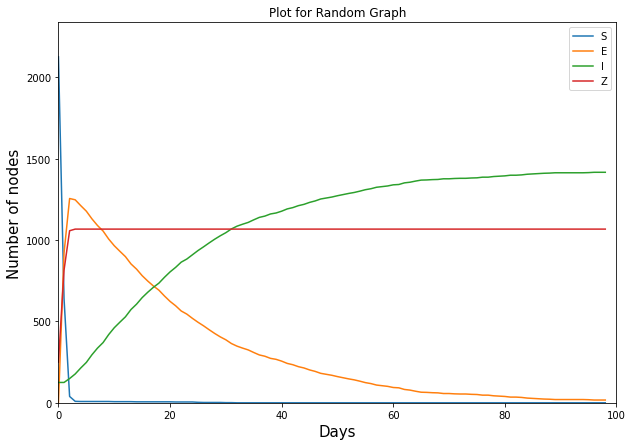

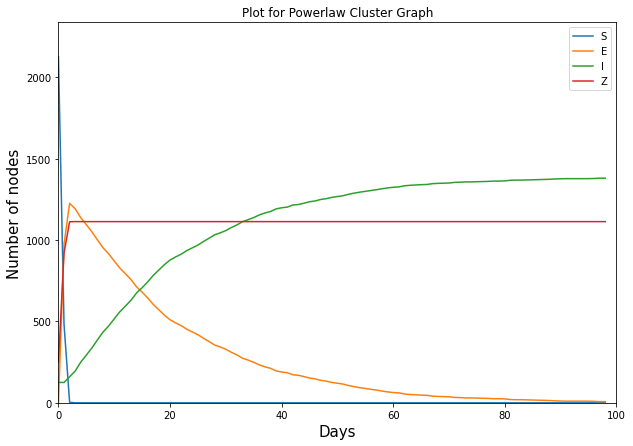

In [4]:
N = 2500
graph_types = ["Random", "Powerlaw Cluster"]

for graph_type in graph_types:
  if graph_type=="Random":
    # Carry out simulations on a random graph
    G = nx.gnp_random_graph(N, p = 0.005, seed=10)

  else:
    # Carry out simulations on a powerlaw cluster graph 
    G = nx.powerlaw_cluster_graph(n = N, m = int(0.005*N), p = 0.01, seed = 10)

  # set the initial number of nodes in states S and I
  num_S, num_I, num_Z = int(0.85*N), int(0.05*N), int(0.1*N)
  all_nodes = list(G.nodes())

  for node in all_nodes:
    G.nodes[node]['state'] = 'S'

  I_nodes = np.random.choice(all_nodes, size=num_I, replace=False)

  for node in I_nodes:
    G.nodes[node]['state'] = 'I'

  Z_nodes = np.random.choice(list(set(all_nodes)-set(I_nodes)), size=num_Z, replace=False)
  for node in Z_nodes:
    G.nodes[node]['state'] = 'Z'

  all_states = list(dict(G.nodes(data='state')).values())
  print("Counts of S, I and Z are = ", all_states.count('S'), all_states.count('I'), all_states.count('Z'))

  t, S, E, I, Z = seiz_simulation(graph = G, tsteps = 100, t1 = 0.60, t2 = 0.05, p = 0.75, l = 0.4, k = 0.05)
  soln = np.asarray([S, E, I, Z]).transpose()
  plot_animation_SEIZ(soln, graph_type)

In [5]:
# Printing degree vs frequency of the graph
# degree_freq = nx.degree_histogram(G)
# degrees = range(len(degree_freq))
# plt.figure(figsize=(12, 8)) 
# plt.plot(degrees, degree_freq,'go-') 
# plt.xlabel('Degree')
# plt.ylabel('Frequency')
# degree_freq = nx.degree_histogram(G)

# Preferential initialization of the nodes based on degree

# # degree which splits the graph into unequal parts
# deg = np.where(np.cumsum(degree_freq)>=0.7*N)[0][0]
# print("Degree for split: ", deg)

# high_degree_nodes = []
# low_degree_nodes = []
# for i in range(len(G)):
#   if G.degree[i]>deg:
#     high_degree_nodes.append(i)
#   else:
#     low_degree_nodes.append(i)

#print(high_degree_nodes, low_degree_nodes)
# percentage_high_degree_nodes = 0.05
# num_high_degree_nodes = int(percentage_high_degree_nodes*num_I)
# num_low_degree_nodes = int(num_I - num_high_degree_nodes)
# i_highdegree = np.random.choice(high_degree_nodes, size = num_high_degree_nodes, replace=False)
# i_lowdegree = np.random.choice(low_degree_nodes, size = num_low_degree_nodes, replace=False)
#I_nodes = np.concatenate((i_highdegree, i_lowdegree))
#print(I_nodes)

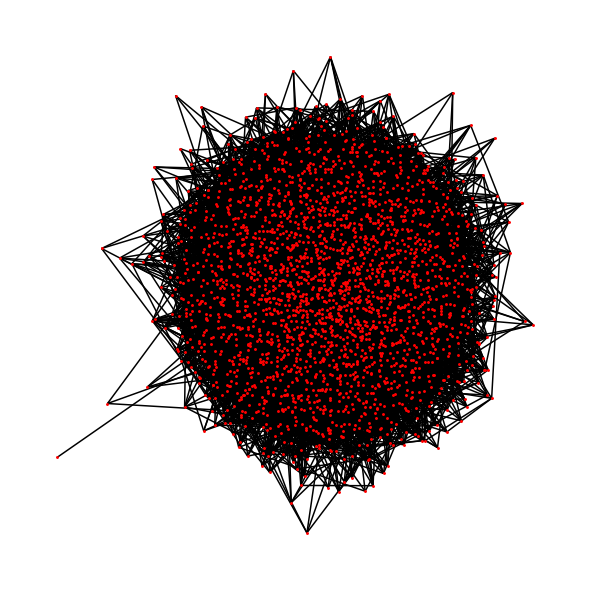

In [6]:
N = 2500
G = nx.gnp_random_graph(N, p = 0.005, seed=10)
plt.figure(figsize=(8,8))
nx.draw(G, node_size=3.5, width = 1.5, node_color='red')

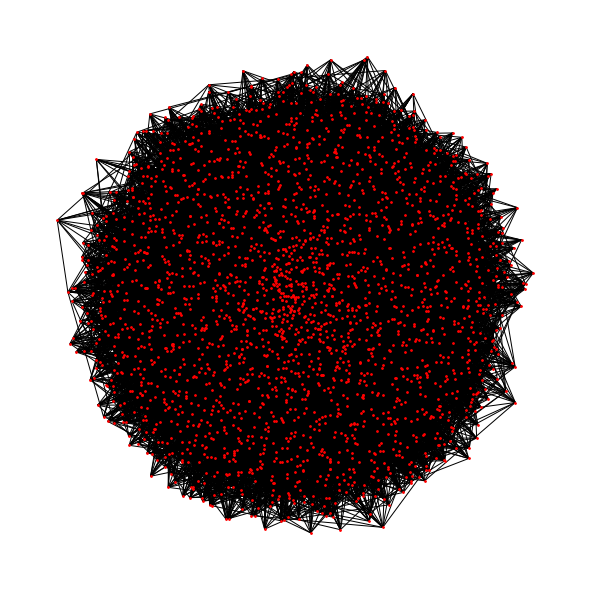

In [7]:
G2 = nx.powerlaw_cluster_graph(n = N, m = int(0.005*N), p = 0.01, seed = 10)
plt.figure(figsize=(8,8))
nx.draw(G2, node_size=3, width = 1, node_color='red')